In [ ]:
# ---
# Title: Wiremind Technical Test - Part 2 : Prediction Model and Evaluation
# Author: Ahmed Hattali
# Date: 28-07-2025
# ---

# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna

## FUNCTIONS

functions definitions for cleaner code in the main and easier readability of steps

### 1. LOAD AND PREPARE DATA

In [2]:
import pandas as pd

def load_data(train_path, test_path):
    """Function to load training and test data from Parquet files"""

    # Read the training dataset from the Parquet file
    train = pd.read_parquet(train_path)
    # Read the testing dataset from the Parquet file
    test = pd.read_parquet(test_path)
    
    return train, test


In [3]:
def transform_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert 'departure_date' and 'sale_date' columns in the dataframe to datetime format.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe containing the columns 'departure_date' and 'sale_date'.

    Returns:
    --------
    pandas.DataFrame
        The dataframe with 'departure_date' and 'sale_date' columns converted to datetime objects.
    """
    df['departure_date'] = pd.to_datetime(df['departure_date'])
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    return df


In [4]:
def one_hot_encode(train_df, test_df, cat_cols):
    """function to encode categorical columns with one hot encoding"""
    combined = pd.concat([train_df, test_df], keys=["train", "test"])
    combined_encoded = pd.get_dummies(combined, columns=cat_cols)
    return (combined_encoded.loc["train"].reset_index(drop=True),
            combined_encoded.loc["test"].reset_index(drop=True))

In [5]:
def remove_route_outliers(df, target='demand', origin_col='origin_station_name', dest_col='destination_station_name',
                          z_thresh=3, min_obs=10):
    """
    Remove outliers by demand z-score per (origin, destination) pair to ensure we don't eliminate normal data for specific routes since they don't have the same scale all of them.
    """
    df = df.copy()
    stats = df.groupby([origin_col, dest_col])[target].agg(['mean', 'std', 'count']).reset_index()
    stats = stats.rename(columns={'mean':'group_mean', 'std':'group_std', 'count':'group_count'})
    df = df.merge(stats, on=[origin_col, dest_col], how='left')
    df['zscore'] = np.where(
        (df['group_std'] > 0),
        (df[target] - df['group_mean']) / df['group_std'],
        0
    )
    cleaned = df[df['zscore'].abs() <= z_thresh].copy()
    return cleaned.drop(columns=['group_mean', 'group_std', 'group_count', 'zscore'])

In [6]:
def scale_data(X_train, X_val):
    """scaling data"""
    scaler = RobustScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_val), scaler

### 2. FEATURE SELECTION

In [7]:
def select_features_rf(X, y, feature_names):
    """Select features using Random Forest."""
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    selector = SelectFromModel(rf, threshold="median", prefit=True)
    selected_features = [feature_names[i] for i, x in enumerate(selector.get_support()) if x]
    return selector.transform(X), selected_features

### 3. MODEL AND EVALUATION

In [8]:
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-5):
    """Calculate the mean absolute percentage error (MAPE)."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.where(np.abs(y_true) > epsilon, np.abs(y_true), np.nan)  # ignore zeros
    mape = np.abs((y_true - y_pred) / denominator)
    return np.nanmean(mape) * 100

In [9]:
def evaluate_regressor(model, X_train, X_val, y_train, y_val):
    """Evaluates a regressor model on the training and validation sets."""
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    metrics = {
        "Train_R2": r2_score(y_train, train_pred),
        "Val_R2": r2_score(y_val, val_pred),
        "Train_RMSE": np.sqrt(mean_squared_error(y_train, train_pred)),
        "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_pred)),
        "Train_MAE": mean_absolute_error(y_train, train_pred),
        "Val_MAE": mean_absolute_error(y_val, val_pred),
        "Val_MAPE": mean_absolute_percentage_error(y_val, val_pred)
    }
    return metrics, model, val_pred

In [10]:
def optimize_xgb(X_train, X_val, y_train, y_val, n_trials=100):
    """Optimize hyperparameters for XGBoost using Optuna."""
    
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "verbosity": 0,
            "booster": "gbtree",
            "tree_method": "auto",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_val, label=y_val)

        evals = [(dvalid, 'validation')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=params["n_estimators"],
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=False,
        )

        preds = model.predict(dvalid, iteration_range=(0, model.best_iteration))
        return np.sqrt(mean_squared_error(y_val, preds))

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study.best_params, study.best_value


In [11]:
def cross_validate_xgb(X, y, params, best_iter, n_folds=5):
    """Perform cross-validation on a set of parameters using XGBoost."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        dtrain = xgb.DMatrix(X[train_idx], label=y.iloc[train_idx])
        dval = xgb.DMatrix(X[val_idx], label=y.iloc[val_idx])

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=best_iter,
            evals=[(dval, 'validation')],
            verbose_eval=False,
        )

        preds = model.predict(dval, iteration_range=(0, model.best_iteration))
        rmses.append(np.sqrt(mean_squared_error(y.iloc[val_idx], preds)))

    print(f"Cross-validation RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")


In [12]:
def safe_mape(y_true, y_pred, epsilon=1e-5):
    """Calculate MAPE with a small epsilon to avoid division by zero."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = np.abs(y_true) > epsilon  # ignore zeros or near zeros
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_group_plot(y_true, y_pred, title="Model Evaluation"):
    """Plot global model predictions"""
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)  # Use safe MAPE here
    over_count = np.sum(y_pred > y_true)
    under_count = np.sum(y_pred < y_true)

    # Plot
    metrics = ['RMSE', 'R²', 'MAPE (%)', 'Overestimations', 'Underestimations']
    values = [rmse, r2, mape, over_count, under_count]
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd']

    plt.figure(figsize=(10, 5))
    bars = plt.bar(metrics, values, color=colors)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.ylabel("Metric Value")
    plt.ylim(0, max(values) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [13]:
def evaluate_by_group_plot(df, group_col):
    """
    Evaluate predictions by groups and plot RMSE, R², MAPE, Over and Under percentages.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: ['y_true', 'y_pred', 'ape', group_col]
    group_col : str
        Column to group by (e.g., 'month', 'od_pair', etc.)
    """
    # Prepare data
    grouped = df.groupby(group_col).apply(lambda sub_df: {
        'RMSE': np.sqrt(mean_squared_error(sub_df['y_true'], sub_df['y_pred'])),
        'R2': r2_score(sub_df['y_true'], sub_df['y_pred']),
        'MAPE': sub_df['ape'].mean() * 100,
        'Over %': 100 * (sub_df['y_pred'] > sub_df['y_true']).mean(),
        'Under %': 100 * (sub_df['y_pred'] < sub_df['y_true']).mean()
    })

    # Convert to DataFrame
    metrics_df = pd.DataFrame(grouped.tolist(), index=grouped.index)

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    colors = {
        'RMSE': '#1f77b4',
        'R2': '#2ca02c',
        'MAPE': '#ff7f0e',
        'Over %': '#d62728',
        'Under %': '#9467bd'
    }

    # Bar plots
    metrics_df[['RMSE', 'R2']].plot(kind='bar', ax=axes[0], color=[colors['RMSE'], colors['R2']])
    axes[0].set_ylabel("Error / Score")
    axes[0].set_title(f"Model Evaluation by {group_col} — RMSE and R²")
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

    metrics_df[['MAPE']].plot(kind='bar', ax=axes[1], color=[colors['MAPE']])
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_title(f"MAPE (%) by {group_col}")
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

    metrics_df[['Over %', 'Under %']].plot(kind='bar', ax=axes[2], color=[colors['Over %'], colors['Under %']])
    axes[2].set_ylabel("Over / Under (%)")
    axes[2].set_title(f"Over- and Under-prediction Rates by {group_col}")
    axes[2].grid(True, axis='y', linestyle='--', alpha=0.5)

    # Common X-axis formatting
    for ax in axes:
        ax.legend(loc='upper right')
        ax.set_xlabel(group_col)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


## MAIN EXECUTION

### Loading data
We load the training and test data from files into dataframes.



In [14]:
# Data directory, please change this to your own directory where the data is stored.
data_dir = 'data'

# Load datasets
train_path = os.path.join(data_dir, 'cayzn_train.parquet')
test_path = os.path.join(data_dir, 'cayzn_test.parquet')

train, test = load_data(train_path, test_path)

### Processing
We convert dates, create a new feature combining origin and destination, remove outliers for each route, and encode categorical columns.

In [ ]:
# transform date to datetime
train = transform_date(train) 
test = transform_date(test)

train['od_pair'] = train['origin_station_name'] + " - " + train['destination_station_name']
test['od_pair'] = test['origin_station_name'] + " - " + test['destination_station_name']

# Remove outliers per (origin, destination) pair
train = remove_route_outliers(train,
                                target="demand",
                                origin_col="origin_station_name",
                                dest_col="destination_station_name",
                                z_thresh=2,)

# Categorical columns for encoding
categorical_cols = ["origin_station_name", "destination_station_name"]

train_encoded, test_encoded = one_hot_encode(train, test, categorical_cols)

In [16]:
# Define feature columns excluding target and dates
exclude_cols = ["demand", "departure_date", "sale_date"]
feature_cols = [c for c in train_encoded.columns if c not in exclude_cols]

X = train_encoded[feature_cols]
y = train_encoded["demand"]

In [17]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# copies for validation later : 
X_val_, y_val_ = X_val.copy(), y_val.copy()

# drop od_pair
X_train.drop(columns=["od_pair"], inplace=True)
X_val.drop(columns=["od_pair"], inplace=True)

# Scale features
X_train_scaled, X_val_scaled, scaler = scale_data(X_train, X_val)

### Features selection
We use a model to pick out the most important features to keep. (and we also check to see if the important features we spotted during the analysis is taken into account here)

In [18]:
# Train model
model_ = XGBRegressor(n_estimators=300, random_state=42)
model_.fit(X_train_scaled, y_train)

# Select features above the median importance
selector = SelectFromModel(model_, threshold='median', prefit=True)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()]
print(f"{len(selected_features)} selected features")

# Transform training data
X_train_sel = selector.transform(X_train_scaled)

# Get indices of selected features for the validation set
selected_indices = [X_train.columns.get_loc(f) for f in selected_features]
X_val_sel = X_val_scaled[:, selected_indices]

19 selected features


### Comparing different models

We train several models and check how well they perform on validation data.

#### DO NOT RUN THIS CELL IF NOT NEEDED

In [ ]:
# Models for comparison
models = [
    (Ridge(alpha=1.0), "Ridge Regression"),
    (RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest"),
    (ExtraTreesRegressor(n_estimators=100, random_state=42), "Extra Trees"),
    (XGBRegressor(n_estimators=100, random_state=42, verbosity=0), "XGBoost"),
    (LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1), "LightGBM"),
]

# Model comparison with new metric MAPE included
print("=== MODEL COMPARISON ===")
for model, name in models:
    metrics, _, _ = evaluate_regressor(model, X_train_sel, X_val_sel, y_train, y_val)
    print(
        f"{name} Validation Metrics:\n"
        f"  R2:  {metrics['Val_R2']:.4f}\n"
        f"  RMSE: {metrics['Val_RMSE']:.4f}\n"
        f"  MAE: {metrics['Val_MAE']:.4f}\n"
        f"  MAPE: {metrics['Val_MAPE']:.2f}%\n"
    )

=== MODEL COMPARISON ===
Ridge Regression Validation Metrics:
  R2:  0.3825
  RMSE: 3.4211
  MAE: 2.3586
  MAPE: 88.26%

Random Forest Validation Metrics:
  R2:  0.7511
  RMSE: 2.1721
  MAE: 1.0857
  MAPE: 65.52%

Extra Trees Validation Metrics:
  R2:  0.7372
  RMSE: 2.2319
  MAE: 1.1056
  MAPE: 67.35%

XGBoost Validation Metrics:
  R2:  0.7560
  RMSE: 2.1503
  MAE: 1.0973
  MAPE: 63.84%

LightGBM Validation Metrics:
  R2:  0.7330
  RMSE: 2.2497
  MAE: 1.1350
  MAPE: 65.34%



Several regression models were tested to compare their ability to predict demand, using consistent evaluation metrics like RMSE, R², and MAPE. After initial checks, XGBoost showed relatively strong performance and was chosen for further tuning. Feature selection was also done to retain only the most informative variables.

### HYPERPARAMETER OPTIMIZATION
We tune the best model’s settings to improve accuracy using a trial-and-error method.

Hyperparameters for XGBoost were optimized using Optuna, a library that automates the search for the best settings. This process helped reduce error, but model performance remained limited by the zero-inflated and skewed nature of the demand data.

In [20]:
best_params, best_rmse = optimize_xgb(X_train_sel, X_val_sel, y_train, y_val, n_trials=50)

[I 2025-07-31 15:27:23,270] A new study created in memory with name: no-name-0c15794e-f4c5-4fd7-ac8a-cc3828bf29fd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-31 15:27:41,851] Trial 0 finished with value: 2.1925300025693626 and parameters: {'n_estimators': 595, 'learning_rate': 0.021227126110795688, 'max_depth': 7, 'min_child_weight': 18, 'subsample': 0.8518175310177469, 'colsample_bytree': 0.6659958700081605, 'reg_alpha': 0.3257029903803955, 'reg_lambda': 9.019203659248467}. Best is trial 0 with value: 2.1925300025693626.
[I 2025-07-31 15:27:53,947] Trial 1 finished with value: 2.048226466062456 and parameters: {'n_estimators': 566, 'learning_rate': 0.11572449497025726, 'max_depth': 15, 'min_child_weight': 51, 'subsample': 0.9001976405031257, 'colsample_bytree': 0.7854225138866209, 'reg_alpha': 0.008014861795702707, 'reg_lambda': 0.0017251730404600374}. Best is trial 1 with value: 2.048226466062456.
[I 2025-07-31 15:28:08,523] Trial 2 finished with value: 2.2411172335761522 and parameters: {'n_estimators': 701, 'learning_rate': 0.0910004259409991, 'max_depth': 4, 'min_child_weight': 91, 'subsample': 0.9481850294779438, 'colsample

In [21]:
## optimized params
final_params = {
    "objective": "reg:squarederror",  # regression objective
    "eval_metric": "rmse",            # Evaluation metric
    "verbosity": 0,
    "random_state": 42,
    **best_params,                    # tuned params here
}

In [22]:
dtrain = xgb.DMatrix(X_train_sel, label=y_train)
dval = xgb.DMatrix(X_val_sel, label=y_val)

In [23]:
# Finding best num_boost_round using cross validation
cv_results = xgb.cv(
    params=final_params,
    dtrain=dtrain,
    nfold=5,
    num_boost_round=1000,
    early_stopping_rounds=50,
    metrics='rmse',
    verbose_eval=100
)
best_iteration = len(cv_results)

[0]	train-rmse:4.27001+0.00421	test-rmse:4.27074+0.01692
[100]	train-rmse:2.15700+0.00226	test-rmse:2.25219+0.01021
[200]	train-rmse:2.00559+0.00174	test-rmse:2.15473+0.00986
[300]	train-rmse:1.92465+0.00135	test-rmse:2.11307+0.01011
[400]	train-rmse:1.86703+0.00173	test-rmse:2.08899+0.00935
[500]	train-rmse:1.82274+0.00197	test-rmse:2.07515+0.00888
[600]	train-rmse:1.78576+0.00227	test-rmse:2.06587+0.00887
[700]	train-rmse:1.75455+0.00222	test-rmse:2.06004+0.00892
[800]	train-rmse:1.72701+0.00196	test-rmse:2.05595+0.00912
[900]	train-rmse:1.70158+0.00215	test-rmse:2.05298+0.00911
[999]	train-rmse:1.68022+0.00214	test-rmse:2.05124+0.00893


### FINAL MODEL
We train the final model on all training data using the tuned settings and selected features.


In [24]:
# Training final model on full training set
final_model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=best_iteration
)

#### MODEL EVALUATION
We check how well the model predicts on validation and test sets, and look at errors by month and route. (for optimization reasons)

In [25]:
val_pred = final_model.predict(dval)

In [26]:
rmse = mean_squared_error(y_val, val_pred, squared=False)
r2 = r2_score(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 2.0206
R2: 0.7846
MAE: 1.0119


In [27]:
val_data = X_val_.copy()
val_data['y_true'] = y_val
val_data['y_pred'] = val_pred
val_data['error'] = val_data['y_true'] - val_data['y_pred']
val_data['abs_error'] = val_data['error'].abs()
val_data['ape'] = (val_data['abs_error'] / val_data['y_true'].replace(0, np.nan)).clip(upper=5)  # Avoid div by zero

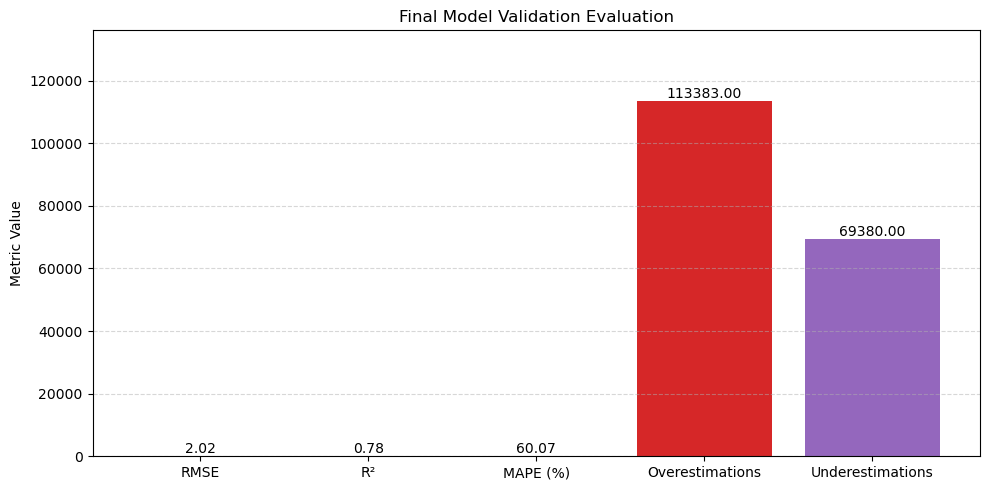

In [30]:
evaluate_group_plot(y_val, val_pred, title="Final Model Validation Evaluation")

On the validation set, the model showed good overall variance explanation (R² = 0.80), but the MAPE was high (around 60%). Most errors came from **overestimating demand**, likely due to the model’s difficulty balancing **frequent zero cases** with **occasional extreme values**. This bias means small mistakes look large in percentage terms, especially for samples with actual demand near zero.

#### EVALUATION BASED ON DIFFRENT AGGREGATIONS

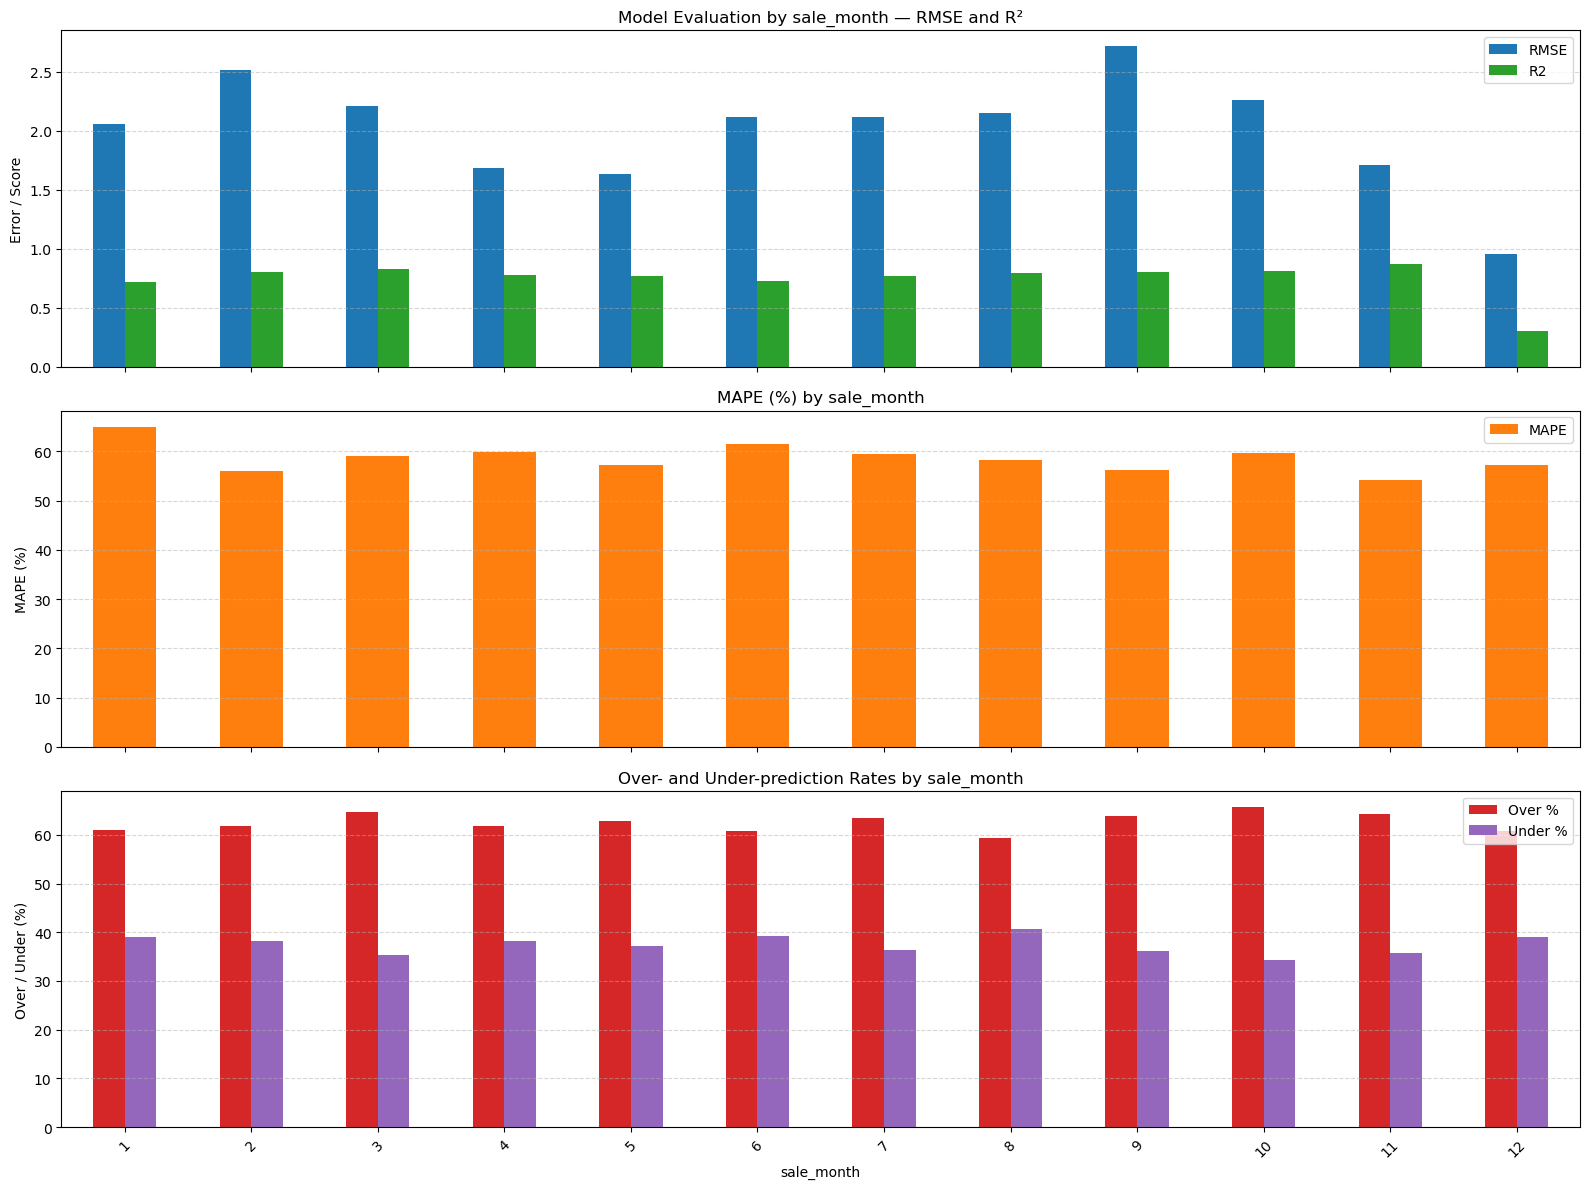

In [31]:
# Plot evaluations by month
evaluate_by_group_plot(val_data, 'sale_month')


The model's monthly performance metrics reveal a systematic prediction bias driven by the distribution of demand values in the dataset. 

the model tends to overestimate demand when the actual demand is low—including the many cases where demand is zero—and underestimate demand when actual demand is high. 

This pattern arises because the dataset contains a large proportion of low and zero demand instances, skewing the model's output towards average values. As a result, over-prediction is common for the majority of cases with low true demand, while the high-demand events are often under-predicted. 

This behavior is reflected in the error metrics by month, which show consistently high MAPE values and a greater proportion of under-predictions overall. Addressing this zero-inflated and imbalanced nature of the data will be crucial for improving both the accuracy and calibration of a future model.

##### Model Evaluation by od_pair 

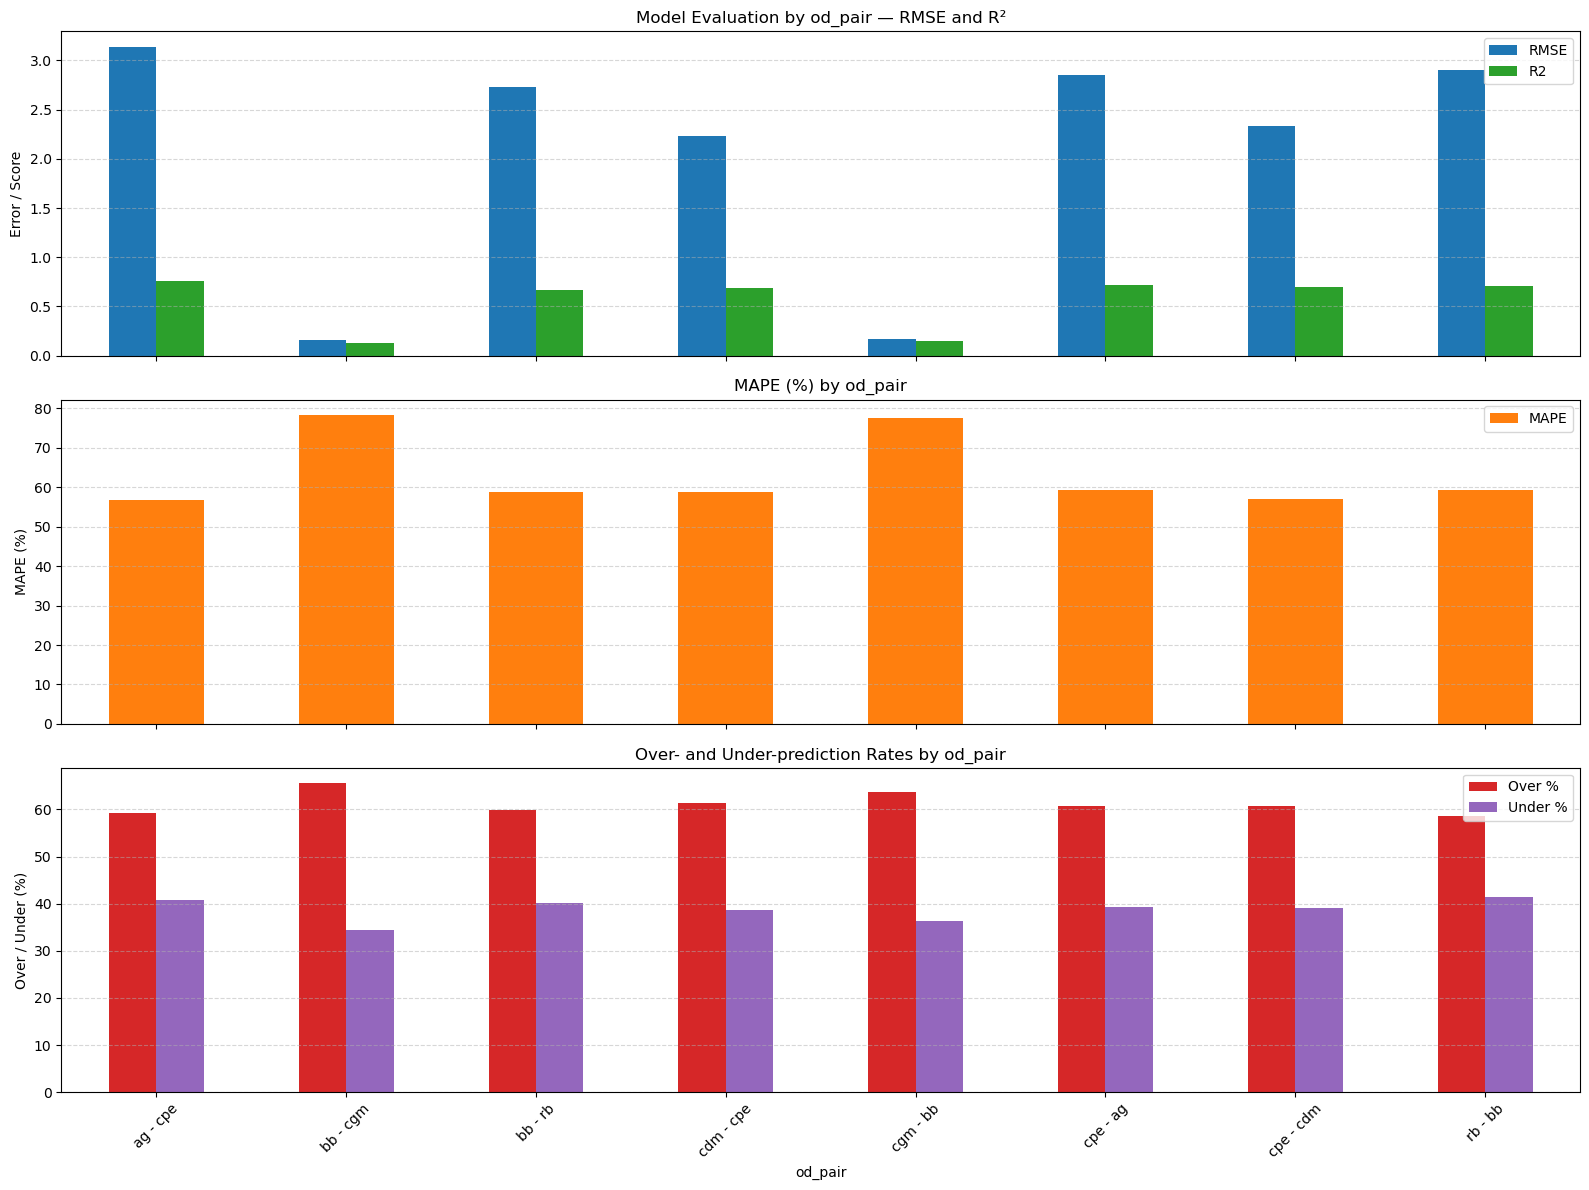

In [32]:
# Plot evaluations by origin destination pair
evaluate_by_group_plot(val_data, 'od_pair')


This set of plots breaks down the model’s performance for each origin-destination pair. The first panel shows RMSE and R²: some routes have much higher errors (RMSE) and lower scores (R²), indicating the model struggles with those specific pairs, likely due to irregular demand or limited data. 

The MAPE plot shows percentage error is especially high for certain routes. the model tends to overpredict demand for nearly all routes (around 57–58% overpredictions), which matches the demand’s zero-inflated distribution. 

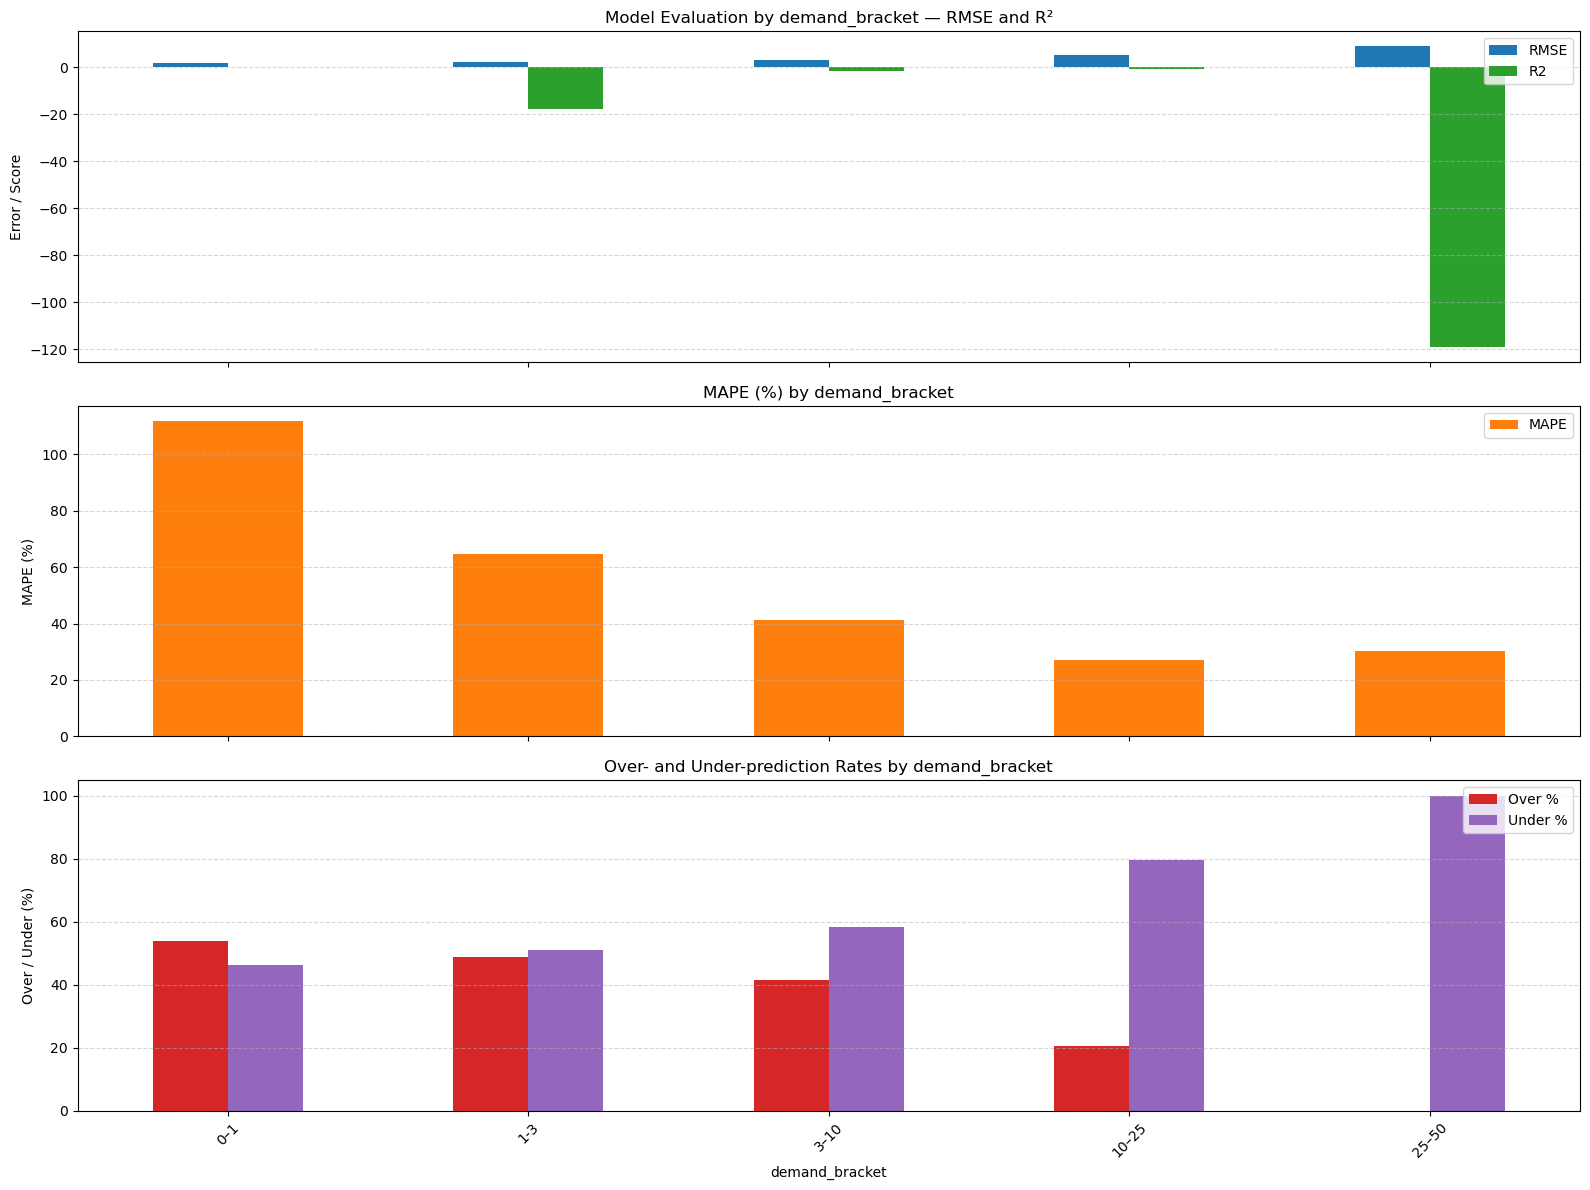

In [33]:
# Plot evaluations by demand bracket
bins = [0,1, 3, 10, 25, 50]
labels = ['0–1','1-3', '3–10', '10–25', '25–50']
val_data['demand_bracket'] = pd.cut(val_data['y_true'], bins=bins, labels=labels)
evaluate_by_group_plot(val_data, 'demand_bracket')

This layered plot above displays how model error and bias change across different demand brackets. 

RMSE and R² show that the model performs poorly at the lowest demand levels, even yielding negative R² in some brackets.

MAPE is extremely high in the lowest brackets (due to very small ground truth values). As actual demand increases, error metrics improve and overprediction drops; however, the model starts to underpredict higher true demands, which is typical when the model is influenced by the large number of low values in the data. This bracketed analysis shows the model is overpredicting low demand and underpredicting high demand cases.

### PREDICTING THE TEST DATA
We check how well the model predicts on the test sets, and look at errors by month and route.

In [34]:
# 2. Extract ground truth
y_test = test_encoded['demand']

# 3. Select features in the same order as training
X_test = test_encoded[X_train.columns].copy()

# 4. Scale
X_test_scaled = scaler.transform(X_test)

# 5. Feature selection
X_test_sel = selector.transform(X_test_scaled)

# 6. Create DMatrix with labels for evaluation
dtest = xgb.DMatrix(X_test_sel, label=y_test)

In [35]:
# Predict with XGBoost Booster (no num_iteration needed if not using early stopping)
test_pred = final_model.predict(dtest)

#### TEST DATA SCORES

In [36]:
rmse = mean_squared_error(y_test, test_pred, squared=False)
r2 = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")

Test RMSE: 4.9414
Test R2: 0.5953
Test MAE: 2.1938


In [37]:
test_data = X_test.copy()
test_data['od_pair'] = test_encoded['od_pair'].values
test_data['y_true'] = y_test.values  # ensure aligned index with y_test
test_data['y_pred'] = test_pred
test_data['error'] = test_data['y_true'] - test_data['y_pred']
test_data['abs_error'] = test_data['error'].abs()
test_data['ape'] = (test_data['abs_error'] / test_data['y_true'].replace(0, np.nan)).clip(upper=5)

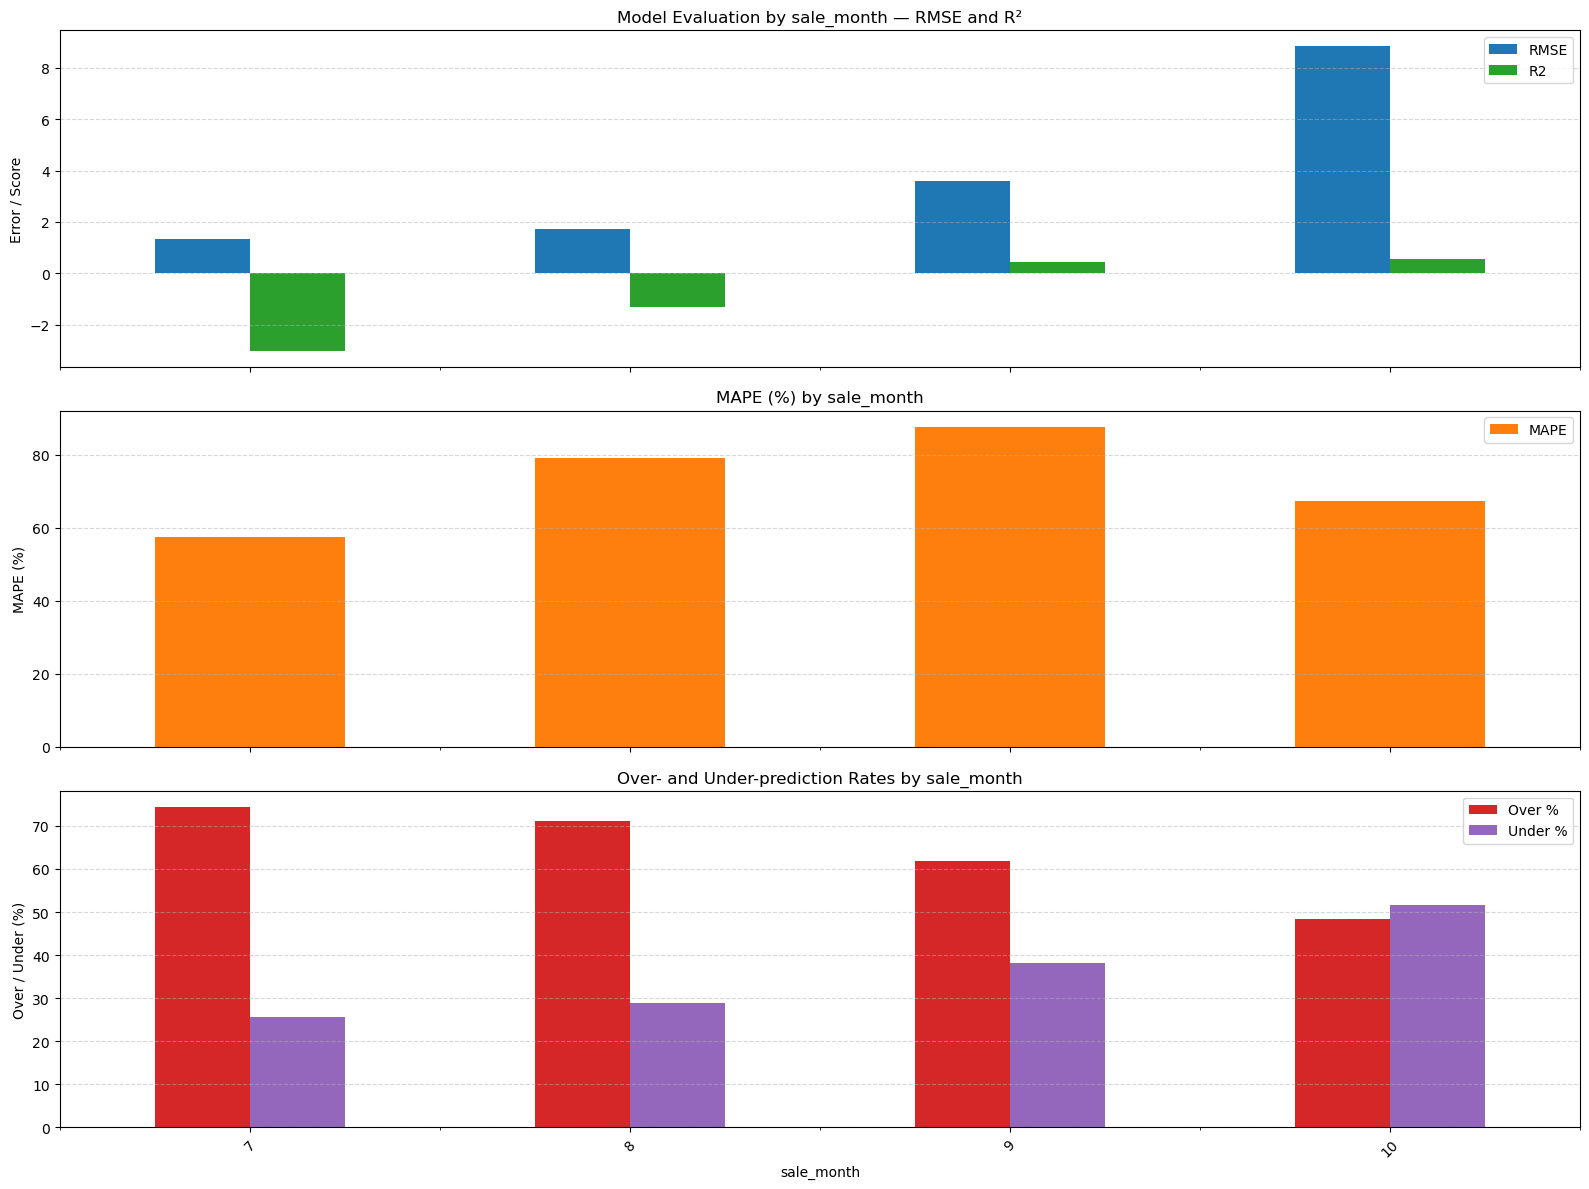

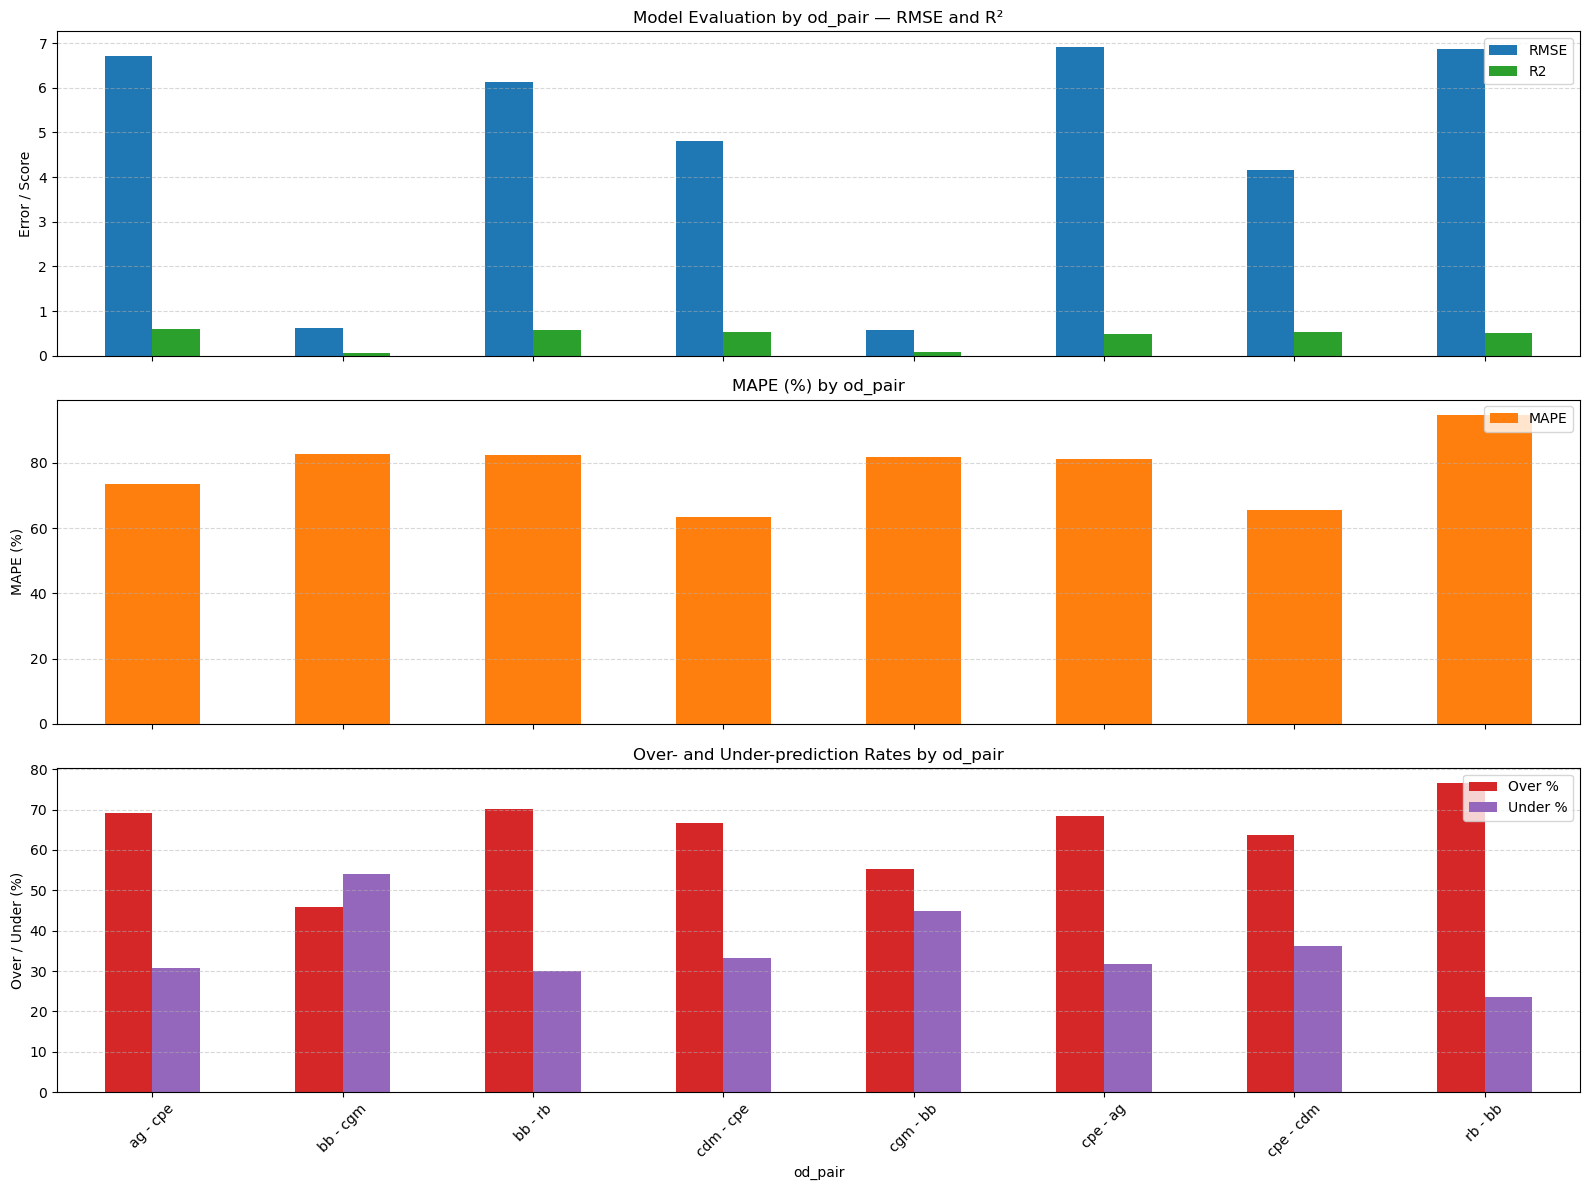

In [38]:
# Plot evaluations by month
evaluate_by_group_plot(test_data, 'sale_month')

# Plot evaluations by origin destination pair
evaluate_by_group_plot(test_data, 'od_pair')

The model’s performance on the test set closely mirrors what was seen on validation. High MAPE and RMSE persist in both, and R² remains low or negative in several brackets, confirming that the model’s errors and over-prediction bias generalize to unseen data. The shortcomings are structural, not due to overfitting.

**Demand Brackets:** The model overpredicts most strongly at low demand levels, with very high MAPE and negative R². For higher demand brackets, MAPE drops but is still substantial, and under-prediction becomes more common.

**Sale Month**: Error rates and over-forecasting remain high and relatively unchanged month to month. The model fails to adapt to seasonality or time-specific changes in demand.

**OD-Pair:** Across all routes, high error and over-prediction are consistent, showing that the model doesn’t capture route-specific demand dynamics.

## CONCLUSIONS

This project focused on predicting train traveler demand using historical sales data. While the model achieved reasonable results on validation data, several challenges in the dataset significantly limited its performance on unseen test data.

Key Observations

- Skewed and Zero-Heavy Target : 
A large portion of the target values were zero, which made accurate modeling difficult. Standard regression models tended to over-predict in low-demand situations and under-predict during high-demand periods.

- High Variability Across Routes : 
Routes differed widely in demand patterns, pricing, and frequency. A single global model could not generalize well across all origin-destination pairs, resulting in inconsistent performance.

- Temporal Irregularities : 
Most data was from 2020, which was impacted by the COVID-19 pandemic. This limited the ability of the model to learn normal seasonal or calendar-based demand patterns.

**Model Performance**

The final XGBoost model achieved moderate performance, with an R² of approximately 0.80 on the validation set. However, performance on the test data revealed notable weaknesses: the model tended to **overestimate low-demand cases** and **underestimate high-demand cases**, indicating potential issues with generalization at the extremes of the demand distribution.

#### Future improvements:

**- Alternative Modeling Approaches**

Use a two-stage model: first predict whether demand is zero or not, then predict demand for the non-zero cases.

**- Temporal Feature Enhancements**

Integrate external features (like weather).

Extend the dataset to cover more typical years to improve seasonality modeling.

**- Post-Prediction Adjustments**

Apply rule-based constraints or smoothing methods to reduce unrealistic predictions.


The modeling pipeline was solid, but performance was mainly limited by the nature of the data: skewed distribution, route heterogeneity, and abnormal time periods. With more representative data and a modeling strategy tailored to the structure of the problem, significant improvements are possible.

